In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Subset
import cv2
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset
import copy
import math
import wandb


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_loc = "drive/MyDrive/rotating_gs"
model_loc = "drive/MyDrive"
entity="HPML-final-team"
project="HPML Final Project"
wandb.login()

wandb.init(
    project="HPML Final Project",
    entity="HPML-final-team",
    name="Unstructured Pruning 6",
)

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
train_data = np.load(f"{data_loc}/train.npz")
val_data = np.load(f"{data_loc}/val.npz")
test_data = np.load(f"{data_loc}/test.npz")

# Visualize Data

In [75]:
print(f"Size of train densities: {train_data['densities'].shape}")
print(f"Size of val densities: {val_data['densities'].shape}")
print(f"Size of test densities: {test_data['densities'].shape}")
print()
print(f"Size of train phase gradients: {train_data['phase_gradients'].shape}")
print(f"Size of val phase gradients: {val_data['phase_gradients'].shape}")
print(f"Size of test phase gradients: {test_data['phase_gradients'].shape}")
print()


Size of train densities: (1008, 200, 200)
Size of val densities: (336, 200, 200)
Size of test densities: (336, 200, 200)

Size of train phase gradients: (1008, 2, 200, 200)
Size of val phase gradients: (336, 2, 200, 200)
Size of test phase gradients: (336, 2, 200, 200)



Text(0.5, 0.98, 'Training Example')

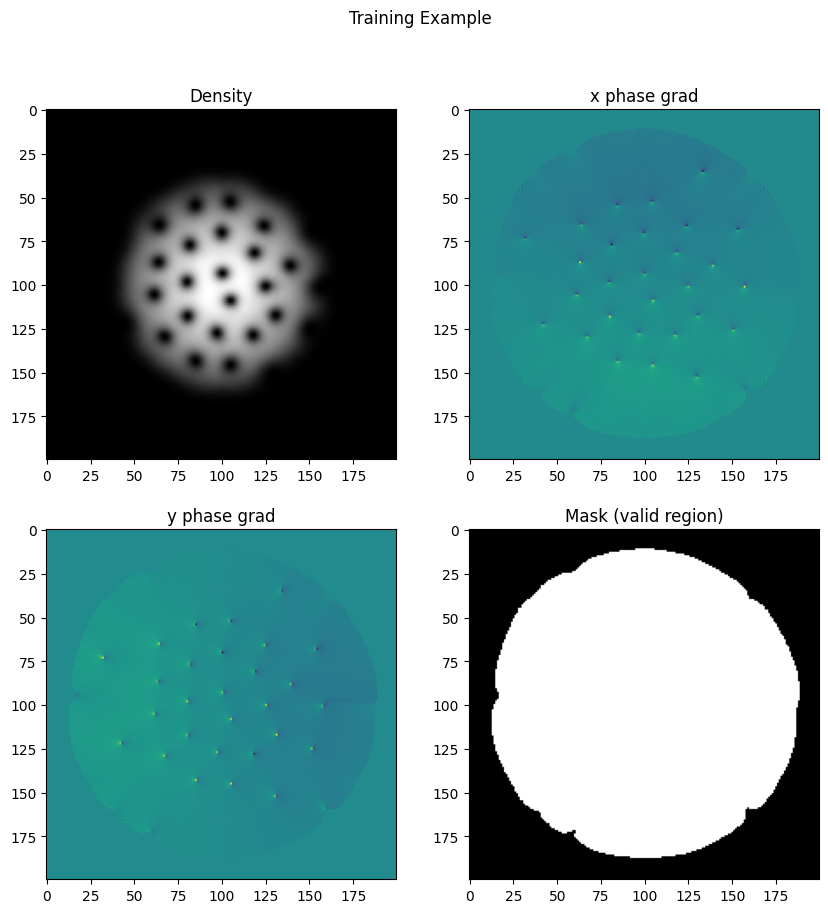

In [76]:
# Visualize an example
idx = 1
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes[0, 0].imshow(train_data['densities'][idx], cmap='gray')
axes[0, 1].imshow(train_data['phase_gradients'][idx, 0])
axes[1, 0].imshow(train_data['phase_gradients'][idx, 1])
axes[1, 1].imshow(1 - train_data['masks'][idx, 0], cmap = 'gray')

axes[0, 0].set_title("Density")
axes[0, 1].set_title("x phase grad")
axes[1, 0].set_title("y phase grad")
axes[1, 1].set_title("Mask (valid region)")

plt.suptitle("Training Example")

# Custom Datasets/Dataloaders

In [77]:
class BecDataset(Dataset):
    def __init__(self, densities, phase_grads, masks, log_eps=1e-9):
        """
        densities: (N, W, W)
        phase_grads: (N, 2, W, W)
        masks: (N, 2, W, W)
        log_eps: added before log() for numerical stability
        """
        self.densities = torch.tensor(densities).float().unsqueeze(1)
        self.phase_grads = torch.tensor(phase_grads).float()
        self.masks = torch.tensor(masks).float()
        self.log_eps = log_eps

    def __len__(self):
        return self.densities.size(0)

    def __getitem__(self, idx):
        density = self.densities[idx]
        density = torch.log(density + self.log_eps)
        phase_grad = self.phase_grads[idx]
        mask = self.masks[idx]
        return density, phase_grad, mask

train_dataset = BecDataset(train_data['densities'], train_data['phase_gradients'], train_data['masks'])
val_dataset = BecDataset(val_data['densities'], val_data['phase_gradients'], val_data['masks'])
test_dataset = BecDataset(test_data['densities'], test_data['phase_gradients'], test_data['masks'])

In [78]:
# Create corresponding dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, num_workers = 2)
test_loader = DataLoader(test_dataset, num_workers = 2)

# UNET Definition

In [79]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels, momentum = 0.2),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, momentum = 0.2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, add_skip = True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.add_skip = add_skip
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        if self.add_skip:
            x = torch.cat([x2, x1], dim=1)
            #print(f"dim after concatenation: {x.shape}")
        else:
            x = x1
        #print(f"Running conv2d with {self.conv.double_conv[0].in_channels} in_channels, {self.conv.double_conv[-3].out_channels} out_channels")
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, channels, bilinear=True, add_skip = True, out_channels = 1, wrap_angles = False, verbose=False):
        super(UNet, self).__init__()
        self.channels = channels
        self.bilinear = bilinear
        self.verbose = verbose
        self.wrap_angles = wrap_angles

        self.inc = DoubleConv(channels[0], channels[1])
        if add_skip:
            #Repeat the final layer to add a skip connection in that layer
            self.downs = nn.ModuleList([Down(channels[i], channels[i+1]) for i in range(1, len(channels)-1)] +
                                       [Down(channels[-1], channels[-1])])
            self.ups = nn.ModuleList([Up(2*channels[i+1], channels[i], bilinear, add_skip) for i in range(len(channels)-2, 0, -1)] +
                                     [Up(2* channels[1], channels[1], bilinear, add_skip)])
        else:
            self.downs = nn.ModuleList([Down(channels[i], channels[i+1]) for i in range(1, len(channels)-1)])
            self.ups = nn.ModuleList([Up(channels[i+1], channels[i], bilinear, add_skip) for i in range(len(channels)-2, 0, -1)])
        self.outc = OutConv(channels[1], out_channels)

    def forward(self, x):
        x_stages = [self.inc(x)]
        if self.verbose:
            print(f"x1 shape: {x_stages[-1].shape}")

        for down in self.downs:
            x_stages.append(down(x_stages[-1]))
            if self.verbose:
                print(f"Down stage shape: {x_stages[-1].shape}")

        x = x_stages.pop()
        for up in self.ups:
            x = up(x, x_stages.pop())
            if self.verbose:
                print(f"Up stage shape: {x.shape}")

        x = self.outc(x)
        if self.verbose:
            print(f"Output shape: {x.shape}")

        #Make between -pi and pi
        if self.wrap_angles:
            x = -F.relu(x + torch.pi) + 2*torch.pi
            x = F.relu(x) - torch.pi
        return x

In [80]:
#Example usage, showing the channel sizes
unet_8 = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], out_channels = 2, verbose = True)
dataiter = iter(train_loader)
images, labels, masks = next(dataiter)
print(images.shape)

output = unet_8(images);

torch.Size([8, 1, 200, 200])
x1 shape: torch.Size([8, 8, 200, 200])
Down stage shape: torch.Size([8, 16, 100, 100])
Down stage shape: torch.Size([8, 32, 50, 50])
Down stage shape: torch.Size([8, 64, 25, 25])
Down stage shape: torch.Size([8, 128, 12, 12])
Down stage shape: torch.Size([8, 256, 6, 6])
Down stage shape: torch.Size([8, 512, 3, 3])
Down stage shape: torch.Size([8, 512, 1, 1])
Up stage shape: torch.Size([8, 256, 3, 3])
Up stage shape: torch.Size([8, 128, 6, 6])
Up stage shape: torch.Size([8, 64, 12, 12])
Up stage shape: torch.Size([8, 32, 25, 25])
Up stage shape: torch.Size([8, 16, 50, 50])
Up stage shape: torch.Size([8, 8, 100, 100])
Up stage shape: torch.Size([8, 8, 200, 200])
Output shape: torch.Size([8, 2, 200, 200])


# Training


In [81]:
def apply_prune_masks(model):
    with torch.no_grad():
        for module in model.modules():
            if hasattr(module, "weight_mask"):
                module.weight_orig.mul_(module.weight_mask)


In [82]:
def predict(dataloader, model, device="cpu"):
    """
    Return *torch tensors* for inputs, predictions, ground_truths, masks, and errors.
    """
    model.eval()
    inputs_list = []
    predictions = []
    ground_truths = []
    masks = []
    with torch.no_grad():
        for inputs, targets, mask_batch in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            mask_batch = mask_batch.to(device)
            preds = model(inputs)

            inputs_list.append(inputs)
            predictions.append(preds)
            ground_truths.append(targets)
            masks.append(mask_batch)

    # Concatenate tensors over batch dimension
    return (
        torch.cat(inputs_list, dim=0),
        torch.cat(predictions, dim=0),
        torch.cat(ground_truths, dim=0),
        torch.cat(masks, dim=0),
    )

def train_model(train_loader, model, loss_fn, optimizer, epochs=10, device="cpu"):

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, targets, masks in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets, masks)
            loss.backward()
            optimizer.step()
            # apply_prune_masks(model) # new

            total_loss += loss.item()

        # Run validation using torch-level predict()
        _, predictions, ground_truths, masks = predict(
            val_loader, model, device=device
        )
        val_loss = loss_fn(predictions, ground_truths, masks).item()

        print(f"Epoch {epoch+1} Train Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}")

In [83]:
#Custom Loss function
#Ignores losses for masked out regions (mask = 1), as these are
#Low density regions and we don't care whether we get them right or not

def mse_with_mask(outputs, targets, masks, keep_first_dim = False):
    if keep_first_dim:
        return torch.mean(((outputs-targets)**2)*(1-masks), dim = (-1, -2, -3))
    else:
        return torch.mean(((outputs-targets)**2)*(1-masks))

unet_8 = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], out_channels = 2)
optimizer = optim.Adam(unet_8.parameters(), lr=1e-3)

train_model(train_loader, unet_8, mse_with_mask, optimizer, epochs=10, device=device)

Epoch 1 Train Loss: 0.007160946157657438, Val Loss: 0.00432635098695755
Epoch 2 Train Loss: 0.0036381359622325925, Val Loss: 0.003527725348249078
Epoch 3 Train Loss: 0.0031629895296184317, Val Loss: 0.0030987097416073084
Epoch 4 Train Loss: 0.0027330899740465814, Val Loss: 0.002504266332834959
Epoch 5 Train Loss: 0.0024410782295042678, Val Loss: 0.0022949930280447006
Epoch 6 Train Loss: 0.0022406173631593232, Val Loss: 0.0020744758658111095
Epoch 7 Train Loss: 0.00204784646981381, Val Loss: 0.0019964203238487244
Epoch 8 Train Loss: 0.0018824742717062316, Val Loss: 0.001753074349835515
Epoch 9 Train Loss: 0.001788984810460418, Val Loss: 0.001680261455476284
Epoch 10 Train Loss: 0.001653327243513472, Val Loss: 0.001579735311679542


# Test Set Evaluation

In [84]:
# Get test predictions
inputs, predictions, truths, masks = predict(test_loader, unet_8, device = device)
errors = mse_with_mask(predictions, truths, masks, keep_first_dim = True)
baseline_mse = errors.mean()

print(f"Error on the testing set: {baseline_mse}")

Error on the testing set: 0.0015598498284816742


In [85]:
# Convert to numpy arrays
inputs = inputs.cpu().numpy()
predictions = predictions.cpu().numpy()
truths = truths.cpu().numpy()
masks = masks.cpu().numpy()
errors = errors.cpu().numpy()

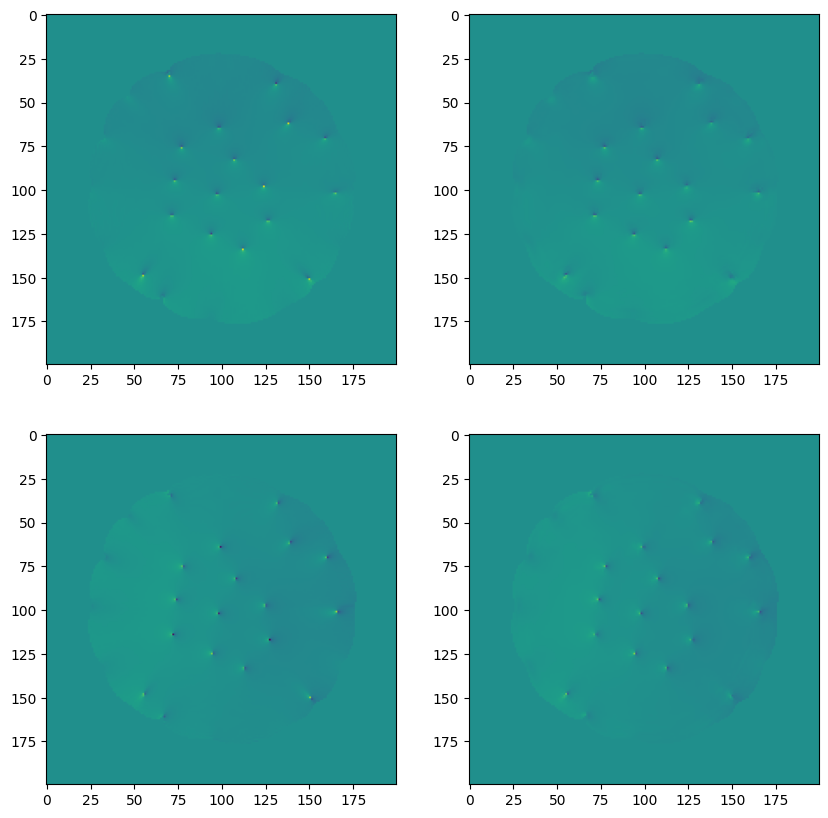

In [86]:
# Visualize a prediction
idx = 1
vmin = truths.min()
vmax = truths.max()
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

axes[0, 0].imshow(truths[idx, 0], vmin = vmin, vmax = vmax)
axes[0, 1].imshow(predictions[idx, 0] * (1 - masks[idx, 0]), vmin = vmin, vmax = vmax)
axes[1, 0].imshow(truths[idx, 1], vmin = vmin, vmax = vmax)
axes[1, 1].imshow(predictions[idx, 1] * (1 - masks[idx, 0]), vmin = vmin, vmax = vmax)

Text(0, 0.5, 'Frequency')

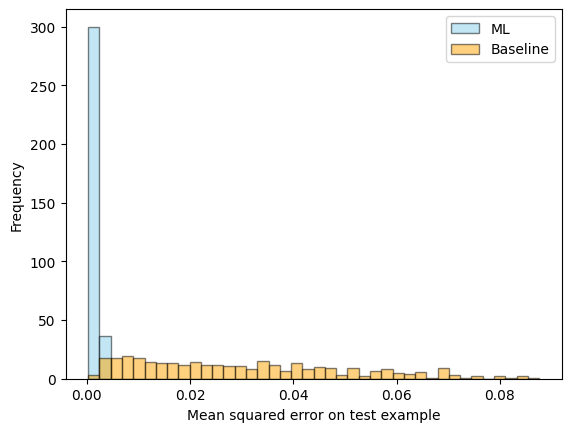

In [87]:
# Histogram of model test set errors and baseline errors.
baseline_errors = np.var(truths, axis = (-1, -2, -3))
all_errors = np.concatenate([errors, baseline_errors])

bin_edges = np.histogram_bin_edges(all_errors, bins=40)
plt.hist(errors, alpha = 0.5, bins = bin_edges, label = "ML", color='skyblue', edgecolor='black')
plt.hist(baseline_errors, alpha = 0.5, bins = bin_edges, label = "Baseline", color='orange', edgecolor='black')
plt.legend()
plt.xlabel("Mean squared error on test example")
plt.ylabel("Frequency")

In [88]:
import torch
import numpy as np
import matplotlib.pyplot as plt

bins = 1000

def plot_weight_histogram(model, bins, log_switch):
  eps = 1e-15
  vals = []
  for module in model.modules():
    if hasattr(module, "weight"):
        if hasattr(module, "weight_mask"):
            w = module.weight_orig.detach().cpu().numpy()
            m = module.weight_mask.detach().cpu().numpy()
            vals.append(w[m == 1])
        else:
            vals.append(module.weight.detach().cpu().numpy().ravel())

  all_vals = np.concatenate(vals)
  all_vals = all_vals[abs(all_vals) > eps]
  print(f'Number of paramaters: ', len(all_vals))

  mean = np.mean(all_vals)
  std = np.std(all_vals)
  max = np.max(all_vals)
  min = np.min(all_vals)
  print(f"Mean: {mean}, std: {std}, max: {max}, min: {min}")
  log_vals = np.log10(abs(all_vals + eps))

  fig, ax = plt.subplots(figsize=(7, 5))
  ax.hist(all_vals, bins=bins, edgecolor='black', log=log_switch)
  ax.set_xlim([-0.06,0.06])
  ax.set_ylim([0,1.2e6])
  ax.set_xlabel("Weight value")
  ax.set_ylabel("Count")
  # ax.set_title("Model Weight Histogram")
  ax.grid(True, linestyle=":", alpha=0.5)

  wandb.log(
      {"weights/histogram": wandb.Image(fig)},
      step=None
  )

Number of paramaters:  17305408
Mean: 0.00012498801515903324, std: 0.019564218819141388, max: 1.1229803562164307, min: -0.39379143714904785


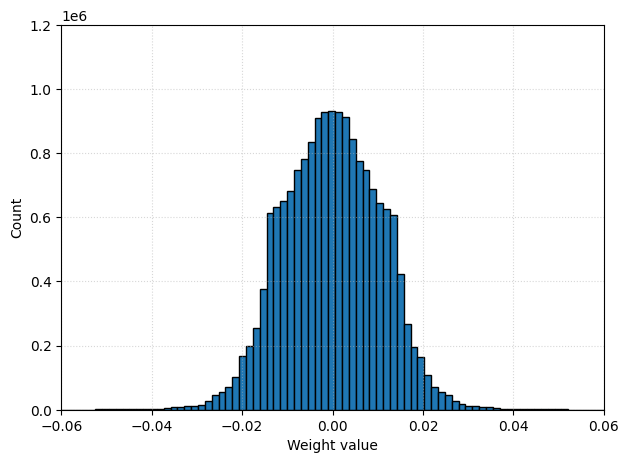

In [89]:
plot_weight_histogram(unet_8, bins, False)

In [90]:
# pruning function

import torch.nn.utils.prune as prune

def prune_global_torch_prune(model, percent):
    parameters_to_prune = []
    for module in model.modules():

        if hasattr(module, 'weight') and module.weight is not None:
            parameters_to_prune.append((module, 'weight'))

    # amount = percent / 100.0

    ## START ##

    desired = percent / 100.0
    total = 0
    zeroed = 0
    for module, name in parameters_to_prune:
        mask = getattr(module, f'{name}_mask', None)
        if mask is None:
            tensor = getattr(module, name).detach()
            total += tensor.numel()
            zeroed += (tensor.abs() == 0).sum().item()
        else:
            total += mask.numel()
            zeroed += (mask == 0).sum().item()
    current = zeroed / total if total > 0 else 0.0
    if desired <= current:
        return 100.0 * current
    amount = (desired - current) / (1.0 - current)

    ## END ##

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount
    )

    total = 0
    zeroed = 0
    for module, name in parameters_to_prune:
        mask = getattr(module, f'{name}_mask', None)
        if mask is None:
            tensor = getattr(module, name).detach()
            total += tensor.numel()
            zeroed += (tensor.abs() == 0).sum().item()
        else:
            total += mask.numel()
            zeroed += (mask == 0).sum().item()
    return 100.0 * zeroed / total


In [91]:
# calculate mse, taken from code above and made into a function

def evaluate_mse(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        inputs, predictions, truths, masks = predict(
            dataloader,
            model,
            device=device
        )
        errors = mse_with_mask(
            predictions,
            truths,
            masks,
            keep_first_dim=True
        )
        return errors.mean().item()



In [92]:
# save dense baseline

dense_state = {
    "dense_model": unet_8.state_dict()
}
torch.save(dense_state, "unet_dense.pth")

In [93]:
# generate a new model

def get_new_model():
  model_new = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], out_channels = 2)
  model_new.load_state_dict(dense_state["dense_model"])
  model_new.to(device)
  return model_new


In [94]:
def zero_fraction(model):
    zeros = 0
    total = 0
    for p in model.parameters():
        zeros += (p == 0).sum().item()
        total += p.numel()
    return zeros / total

In [95]:
# perform a sweep through a number of different percentages of weights to prune (prune 50% of weights, 75%, 90%, etc.)

def prune_sweep_and_plot(test_loader, device, prune_fn, baseline_mse, percentages, retrain):

  print(f'Retrain Type: ', retrain)
  print('\n')

  if retrain == 'Cumulative':
    model = get_new_model()
    wandb.log(
    {"cumulative/zero_fraction": zero_fraction(model)}
    )

  results = []



  for pct in percentages:

    if not retrain or retrain == 'Iterative':
      model = get_new_model()
      print('Generated a new model')

    actual_pruned = prune_fn(model, pct)
    mse_before_retrain = evaluate_mse(model, test_loader, device)

    print(f"   Pruned requested {pct:.2f}% -> actual {actual_pruned:.2f}% ")
    print(f"      MSE without retraining = {mse_before_retrain:.6e}\n")

    if retrain == 'Cumulative':
      wandb.log(
      {"cumulative/zero_fraction": zero_fraction(model)}
      )


    if retrain == 'Iterative' or retrain == 'Cumulative':

      if retrain == 'Cumulative':
        apply_prune_masks(model)

      optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
      train_model(train_loader, model, mse_with_mask, optimizer, epochs=3, device=device)

      mse_after_retrain = evaluate_mse(model, test_loader, device)
      results.append((pct, actual_pruned, mse_after_retrain))

      print(f"\n     MSE after retraining = {mse_after_retrain:.6e}\n")

      if retrain == 'Cumulative':
        wandb.log(
        {"cumulative/zero_fraction": zero_fraction(model)}
        )

    else:

      results.append((pct, actual_pruned, mse_before_retrain))

  percentages_actual = [r[1] for r in results]
  mses_percent_drop = [(1 - r[2] / baseline_mse) for r in results]

  return results, mses_percent_drop, model


In [96]:
# print the original mse

print(f'Initial MSE: ', baseline_mse.item())


Initial MSE:  0.0015598498284816742


In [97]:
# define the sweep percentages

sweep_params_no_retrain = [40,50,60,70,80,90]
sweep_params_iterative = [40,50,60,70,80,90,97,99,99.5,99.9]
sweep_params_cumulative = [80,90,97,99,99.5,99.9,99.9]

In [98]:
results_no_retrain, mses_percent_drop_no_retrain, _ = prune_sweep_and_plot(test_loader, device,
                                                                            prune_global_torch_prune,
                                                                            baseline_mse.item(),
                                                                            sweep_params_no_retrain,
                                                                            retrain=False)

Retrain Type:  False


Generated a new model
   Pruned requested 40.00% -> actual 40.00% 
      MSE without retraining = 1.614841e-03

Generated a new model
   Pruned requested 50.00% -> actual 50.00% 
      MSE without retraining = 1.694803e-03

Generated a new model
   Pruned requested 60.00% -> actual 60.00% 
      MSE without retraining = 2.051343e-03

Generated a new model
   Pruned requested 70.00% -> actual 70.00% 
      MSE without retraining = 2.739433e-03

Generated a new model
   Pruned requested 80.00% -> actual 80.00% 
      MSE without retraining = 4.783402e-03

Generated a new model
   Pruned requested 90.00% -> actual 90.00% 
      MSE without retraining = 1.484319e-02



In [99]:
results_iterative, mses_percent_drop_iterative, _ = prune_sweep_and_plot(test_loader, device,
                                                                        prune_global_torch_prune,
                                                                        baseline_mse.item(),
                                                                        sweep_params_iterative,
                                                                        retrain='Iterative')

Retrain Type:  Iterative


Generated a new model
   Pruned requested 40.00% -> actual 40.00% 
      MSE without retraining = 1.614841e-03

Epoch 1 Train Loss: 0.0016262028126105192, Val Loss: 0.0015796697698533535
Epoch 2 Train Loss: 0.0014731217104579425, Val Loss: 0.0014427562709897757
Epoch 3 Train Loss: 0.0013908110947037737, Val Loss: 0.0015368550084531307

     MSE after retraining = 1.514062e-03

Generated a new model
   Pruned requested 50.00% -> actual 50.00% 
      MSE without retraining = 1.694803e-03

Epoch 1 Train Loss: 0.0016087728851873959, Val Loss: 0.0015681901713833213
Epoch 2 Train Loss: 0.0014834737392245894, Val Loss: 0.0015075659612193704
Epoch 3 Train Loss: 0.0013893582157805443, Val Loss: 0.0013435854343697429

     MSE after retraining = 1.327176e-03

Generated a new model
   Pruned requested 60.00% -> actual 60.00% 
      MSE without retraining = 2.051343e-03

Epoch 1 Train Loss: 0.001573292875758535, Val Loss: 0.0015140185132622719
Epoch 2 Train Loss: 0.00146

In [100]:
results_cumulative, mses_percent_drop_cumulative, _ = prune_sweep_and_plot(test_loader, device,
                                                                            prune_global_torch_prune,
                                                                            baseline_mse.item(),
                                                                            sweep_params_cumulative,
                                                                            retrain='Cumulative')

Retrain Type:  Cumulative


   Pruned requested 80.00% -> actual 80.00% 
      MSE without retraining = 4.783402e-03

Epoch 1 Train Loss: 0.0015993088655661615, Val Loss: 0.0014924634015187621
Epoch 2 Train Loss: 0.0014472508268053865, Val Loss: 0.0014437061036005616
Epoch 3 Train Loss: 0.001380843909121015, Val Loss: 0.001446090522222221

     MSE after retraining = 1.430120e-03

   Pruned requested 90.00% -> actual 90.00% 
      MSE without retraining = 2.856719e-03

Epoch 1 Train Loss: 0.001333745631171272, Val Loss: 0.0012971324613317847
Epoch 2 Train Loss: 0.0012682112430902346, Val Loss: 0.0012793709756806493
Epoch 3 Train Loss: 0.0012295590076107708, Val Loss: 0.0012288172729313374

     MSE after retraining = 1.207939e-03

   Pruned requested 97.00% -> actual 97.00% 
      MSE without retraining = 2.893205e-02

Epoch 1 Train Loss: 0.0012290314323128394, Val Loss: 0.0012135065626353025
Epoch 2 Train Loss: 0.0011441889177409134, Val Loss: 0.0011430452577769756
Epoch 3 Train Loss:

In [101]:
# plot the sweep results

def plot_accuracy(sweep_params_no_retrain, mses_percent_drop_no_retrain, sweep_params_iterative, mses_percent_drop_iterative, sweep_params_cumulative, mses_percent_drop_cumulative):

  # plt.figure(figsize=(6,3))
  # plt.plot(sweep_params_no_retrain, mses_percent_drop_no_retrain, '-go', linewidth=2)
  # plt.plot(sweep_params_iterative, mses_percent_drop_iterative, '-bs', linewidth=2)
  # plt.plot(sweep_params_cumulative, mses_percent_drop_cumulative, '--^r', linewidth=2)
  # plt.xlim(left=42)
  # plt.xlim(right=102)
  # plt.ylim(bottom=-7)
  # plt.ylim(top=1)
  # plt.xlabel('% of weights pruned')
  # plt.ylabel('% accuracy loss')
  # plt.grid(True)
  # plt.legend(['Pruning', 'Pruning + Finetuning', 'Iterative Pruning + Finetuning'])
  # plt.show()

  fig, ax = plt.subplots(figsize=(7, 5))
  ax.plot(sweep_params_no_retrain, mses_percent_drop_no_retrain, '-go', linewidth=2, label='Pruning')
  ax.plot(sweep_params_iterative, mses_percent_drop_iterative, '-bs', linewidth=2, label='Pruning + Finetuning')
  ax.plot(sweep_params_cumulative, mses_percent_drop_cumulative, '--^r', linewidth=2, label='Iterative Pruning + Fine Tuning')
  ax.set_xlim(left=42)
  ax.set_xlim(right=102)
  ax.set_ylim(bottom=-7)
  ax.set_ylim(top=1)
  ax.set_xlabel('% of weights pruned')
  ax.set_ylabel('% accuracy loss')
  ax.grid(True)
  ax.legend()

  wandb.log(
      {"accuracy/total": wandb.Image(fig)},
      step=None
  )


  print('\n')

  # plt.figure(figsize=(5,2))
  # plt.plot(sweep_params_iterative, mses_percent_drop_iterative, '-bs', linewidth=2)
  # plt.plot(sweep_params_cumulative, mses_percent_drop_cumulative, 'r--^', linewidth=2)
  # plt.xlim(left=91)
  # plt.xlim(right=100)
  # plt.ylim(bottom=-7)
  # plt.ylim(top=1)
  # plt.xlabel('% of weights pruned')
  # plt.ylabel('% accuracy loss')
  # plt.grid(True)
  # plt.legend(['Pruning + Finetuning', 'Iterative Pruning + Finetuning'])
  # plt.show()

  fig, ax = plt.subplots(figsize=(5, 2))
  ax.plot(sweep_params_iterative, mses_percent_drop_iterative, '-bs', linewidth=2, label='Pruning + Finetuning')
  ax.plot(sweep_params_cumulative, mses_percent_drop_cumulative, '--^r', linewidth=2, label='Iterative Pruning + Fine Tuning')
  ax.set_xlim(left=91)
  ax.set_xlim(right=100)
  ax.set_ylim(bottom=-7)
  ax.set_ylim(top=1)
  ax.set_xlabel('% of weights pruned')
  ax.set_ylabel('% accuracy loss')
  ax.grid(True)
  ax.legend()

  wandb.log(
      {"accuracy/zoomed": wandb.Image(fig)},
      step=None
  )

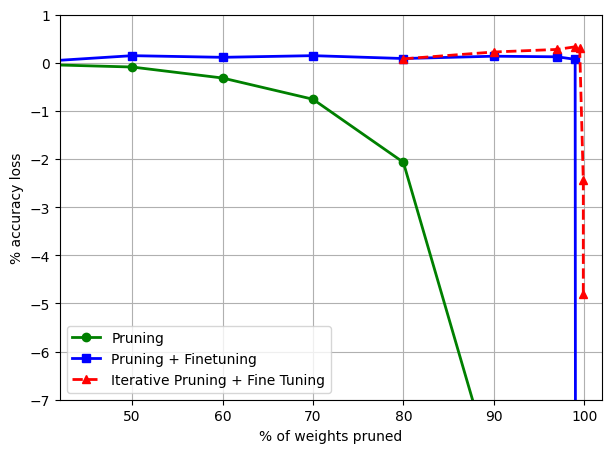

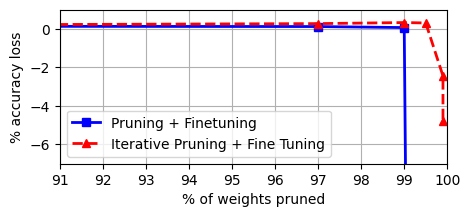

In [102]:
plot_accuracy(sweep_params_no_retrain, mses_percent_drop_no_retrain, sweep_params_iterative, mses_percent_drop_iterative, sweep_params_cumulative, mses_percent_drop_cumulative)

In [103]:
# plot new histograms with 80% pruning

# no retraining

_, _, final_model_no_retrain = prune_sweep_and_plot(test_loader, device,
                                                    prune_global_torch_prune,
                                                    baseline_mse.item(),
                                                    percentages=[75],
                                                    retrain=False)

Retrain Type:  False


Generated a new model
   Pruned requested 75.00% -> actual 75.00% 
      MSE without retraining = 3.380057e-03



Number of paramaters:  4326352
Mean: 0.0006306417053565383, std: 0.037309709936380386, max: 1.1229803562164307, min: -0.39379143714904785


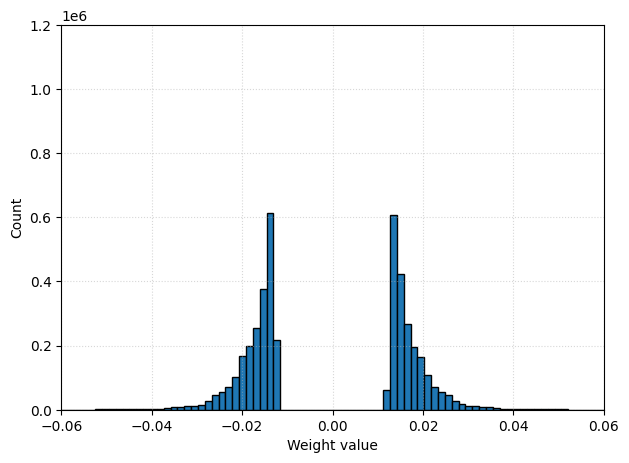

In [104]:
plot_weight_histogram(final_model_no_retrain, bins, False)

In [105]:
_, _, final_model_iterative = prune_sweep_and_plot(test_loader, device,
                                                    prune_global_torch_prune,
                                                    baseline_mse.item(),
                                                    percentages=[75],
                                                    retrain='Iterative')

Retrain Type:  Iterative


Generated a new model
   Pruned requested 75.00% -> actual 75.00% 
      MSE without retraining = 3.380057e-03

Epoch 1 Train Loss: 0.0015937516101754256, Val Loss: 0.0014973478391766548
Epoch 2 Train Loss: 0.0014327560876688315, Val Loss: 0.0014608585042878985
Epoch 3 Train Loss: 0.0013944753385629386, Val Loss: 0.0016299496637657285

     MSE after retraining = 1.605529e-03



Number of paramaters:  4326352
Mean: 0.0003871425869874656, std: 0.03745046257972717, max: 1.141237735748291, min: -0.3904390037059784


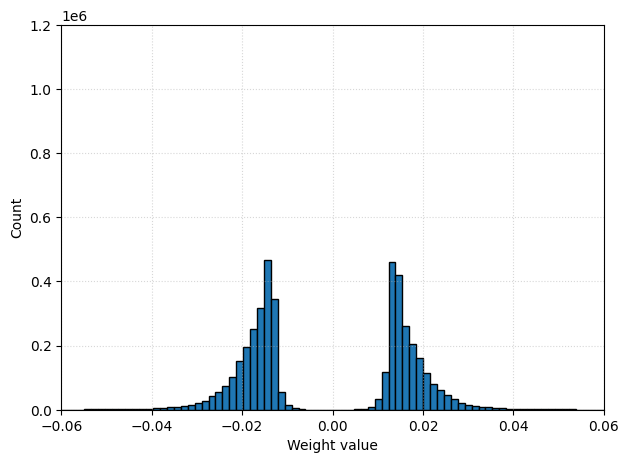

In [106]:
plot_weight_histogram(final_model_iterative, bins, False)

In [107]:
wandb.finish()

cumulative/zero_fraction,▁▁▇▇▇▇█████████
cumulative/zero_fraction,0.99847
